# **CO7093 - Big Data & Predictive Analytics**

##Part 1: Building a basic predictive model for COVID-19 ICU prediction

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, roc_curve
)
from imblearn.over_sampling import SMOTE

# Setting plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')

###1. DATA LOADING AND EXPLORATION

In [9]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData 2025/Dataset.csv', low_memory=False)

# Check dataset shape
print(f"Original dataset shape: {df.shape}")

# Display the first few rows
print("\nFirst 5 rows:")
print(df.head())

# Display data types of each column
print("\nData types:")
print(df.dtypes)

# Display number of unique values per column
print("\nUnique values per column:")
print(df.nunique())

Original dataset shape: (200031, 22)

First 5 rows:
   index  USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED INTUBED  \
0      2      2             1    2             2  09/06/2020       1   
1      5      2             1    1             2  9999-99-99       2   
2      8      2             1    1             2  9999-99-99       2   
3      9      2             1    1             2  9999-99-99       2   
4     11      2             1    2             2  9999-99-99       2   

  PNEUMONIA  AGE PREGNANT  ... ASTHMA INMSUPR HIPERTENSION OTHER_DISEASE  \
0         2   55        ?  ...      2       2            2             2   
1         1   40        2  ...      2       2            2             2   
2         2   37        2  ...      2       2            1             2   
3         2   25        2  ...      2       2            2             2   
4         2   24        ?  ...      2       2            2             2   

  CARDIOVASCULAR OBESITY RENAL_CHRONIC TOBACCO CLASIFFICAT

###2. DATA CLEANING AND PREPROCESSING

Dataset shape after dropping irrelevant columns: (200031, 16)

Missing values before handling:
SEX                        0
INTUBED                 7325
PNEUMONIA               5144
AGE                        0
DIABETES                1195
COPD                    1064
ASTHMA                  1066
INMSUPR                 1280
HIPERTENSION            1106
OTHER_DISEASE           2074
CARDIOVASCULAR          1143
OBESITY                 1113
RENAL_CHRONIC           1074
TOBACCO                 1126
CLASIFFICATION_FINAL       0
ICU                     7488
dtype: int64
Total missing values: 32198

Rows removed due to missing values: 10445 (5.22%)

Missing values after handling:
SEX                     0
INTUBED                 0
PNEUMONIA               0
AGE                     0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL

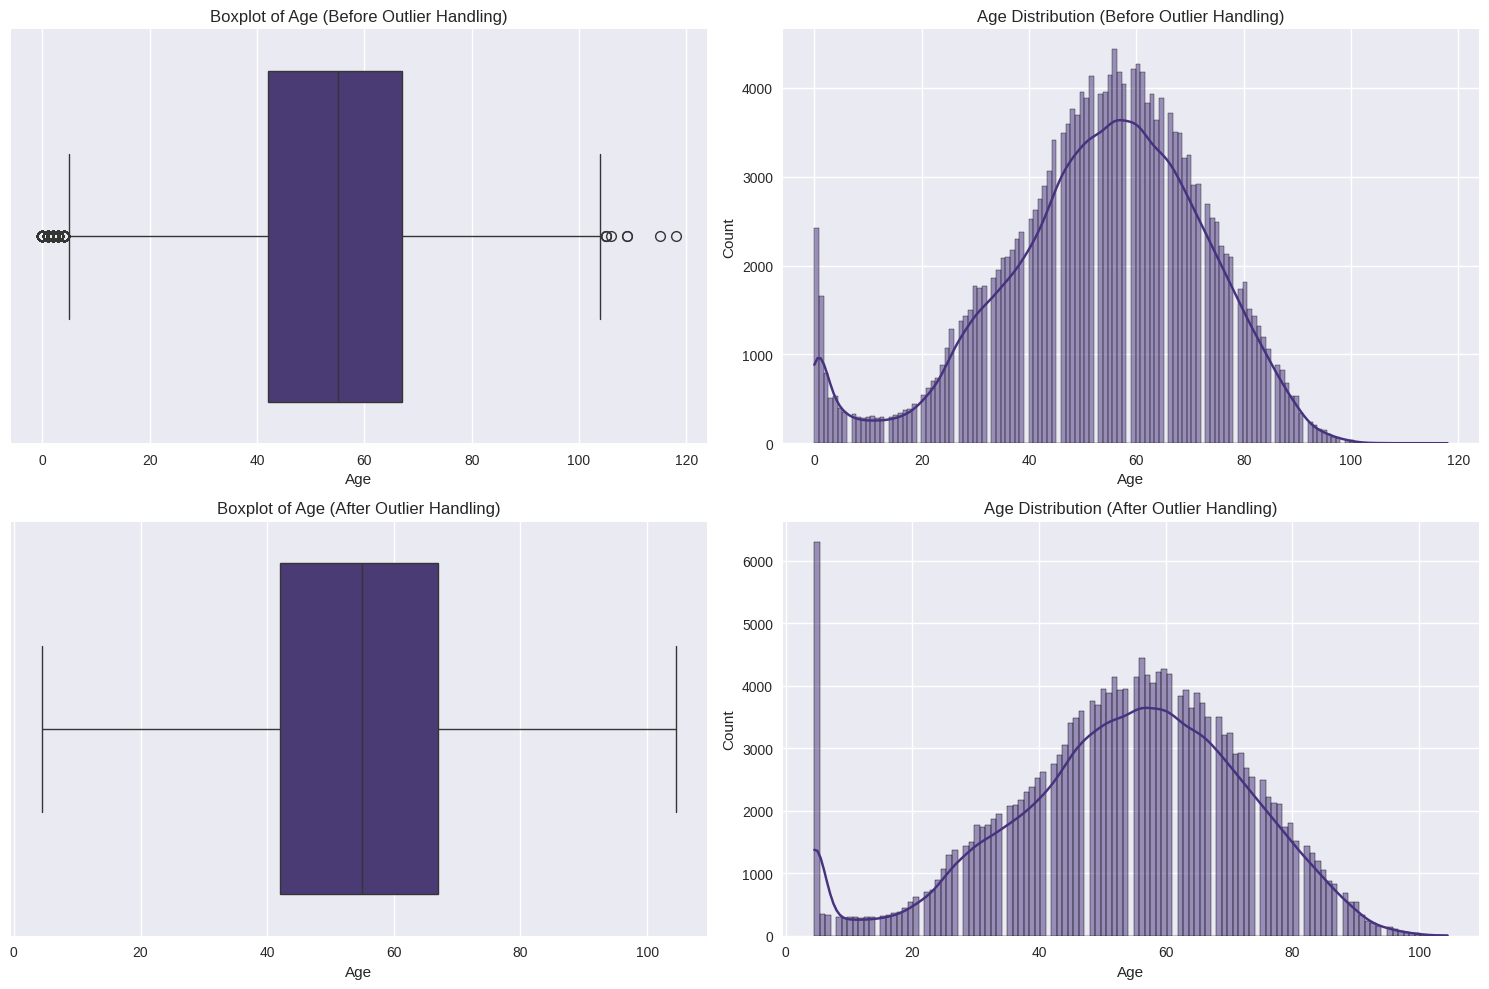

In [10]:
#  Drop irrelevant columns
columns_to_drop = [
    'index',           # Redundant ID column
    'USMER',           # Administrative flag
    'MEDICAL_UNIT',    # Hospital ID, not relevant for prediction
    'PATIENT_TYPE',    # Has only one unique value (2)
    'PREGNANT',        # Not relevant for entire population
    'DATE_DIED'        # Target leakage - only known after ICU decision
]

df_cleaned = df.drop(columns=columns_to_drop)
print(f"Dataset shape after dropping irrelevant columns: {df_cleaned.shape}")

#  Replace placeholder missing values ('?') with actual NaN
df_cleaned.replace('?', np.nan, inplace=True)

# Check missing values before handling
print("\nMissing values before handling:")
missing_before = df_cleaned.isnull().sum()
print(missing_before)
print(f"Total missing values: {missing_before.sum()}")

#  Convert all columns to appropriate numeric types
for col in df_cleaned.columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Recode binary features to 0/1 format instead of 1/2
binary_cols = [
    'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA',
    'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
    'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU'
]

for col in binary_cols:
    if col in df_cleaned.columns:
        # Convert 1/2 encoding to 1/0 encoding (1=Yes, 2=No becomes 1=Yes, 0=No)
        df_cleaned[col] = df_cleaned[col].map({1.0: 1, 2.0: 0})

# Drop rows with missing values (aggressive approach for Part 1)
df_cleaned_no_nulls = df_cleaned.dropna()

# Report number of rows removed
rows_removed = df_cleaned.shape[0] - df_cleaned_no_nulls.shape[0]
print(f"\nRows removed due to missing values: {rows_removed} ({rows_removed/df_cleaned.shape[0]*100:.2f}%)")

# Check if we have enough data left
if df_cleaned_no_nulls.shape[0] == 0:
    print("ERROR: All rows were removed during null handling. Using a less aggressive approach.")
    # Use imputation instead of dropping
    from sklearn.impute import SimpleImputer

    # For binary features, use most frequent value (mode)
    binary_imputer = SimpleImputer(strategy='most_frequent')
    binary_features = [col for col in binary_cols if col in df_cleaned.columns]
    if binary_features:
        df_cleaned[binary_features] = binary_imputer.fit_transform(df_cleaned[binary_features])

    # For numeric features, use median
    numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_imputer = SimpleImputer(strategy='median')
    df_cleaned[numeric_cols] = numeric_imputer.fit_transform(df_cleaned[numeric_cols])

    # Use the imputed dataframe
    df_cleaned_no_nulls = df_cleaned

# Check missing values after handling
print("\nMissing values after handling:")
print(df_cleaned_no_nulls.isnull().sum())
print(f"Total missing values: {df_cleaned_no_nulls.isnull().sum().sum()}")

# Create age groups for better analysis
df_cleaned_no_nulls['AGE_GROUP'] = pd.cut(
    df_cleaned_no_nulls['AGE'],
    bins=[0, 20, 40, 60, 80, 120],
    labels=['0-19', '20-39', '40-59', '60-79', '80+']
)

# Handle outliers in AGE - using capping instead of removal
# Calculate outlier boundaries
Q1 = df_cleaned_no_nulls['AGE'].quantile(0.25)
Q3 = df_cleaned_no_nulls['AGE'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = max(0, Q1 - 1.5 * IQR)  # Ensure non-negative age
upper_bound = Q3 + 1.5 * IQR

# Create a copy of the data before handling outliers for comparison
df_before_outlier_handling = df_cleaned_no_nulls.copy()

# Plot boxplot and histogram for AGE column before outlier handling
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# Boxplot of Age before outlier handling
plt.subplot(2, 2, 1)
sns.boxplot(x=df_before_outlier_handling['AGE'])
plt.title('Boxplot of Age (Before Outlier Handling)')
plt.xlabel('Age')

# Histogram of Age before outlier handling
plt.subplot(2, 2, 2)
sns.histplot(data=df_before_outlier_handling, x='AGE', kde=True)
plt.title('Age Distribution (Before Outlier Handling)')
plt.xlabel('Age')
plt.ylabel('Count')

# Instead of removing outliers, cap them to prevent data loss
df_no_outliers = df_cleaned_no_nulls.copy()
df_no_outliers['AGE'] = df_no_outliers['AGE'].clip(lower=lower_bound, upper=upper_bound)

# Boxplot of Age after outlier handling
plt.subplot(2, 2, 3)
sns.boxplot(x=df_no_outliers['AGE'])
plt.title('Boxplot of Age (After Outlier Handling)')
plt.xlabel('Age')

#  Histogram of Age after outlier handling
plt.subplot(2, 2, 4)
sns.histplot(data=df_no_outliers, x='AGE', kde=True)
plt.title('Age Distribution (After Outlier Handling)')
plt.xlabel('Age')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
plt.close()

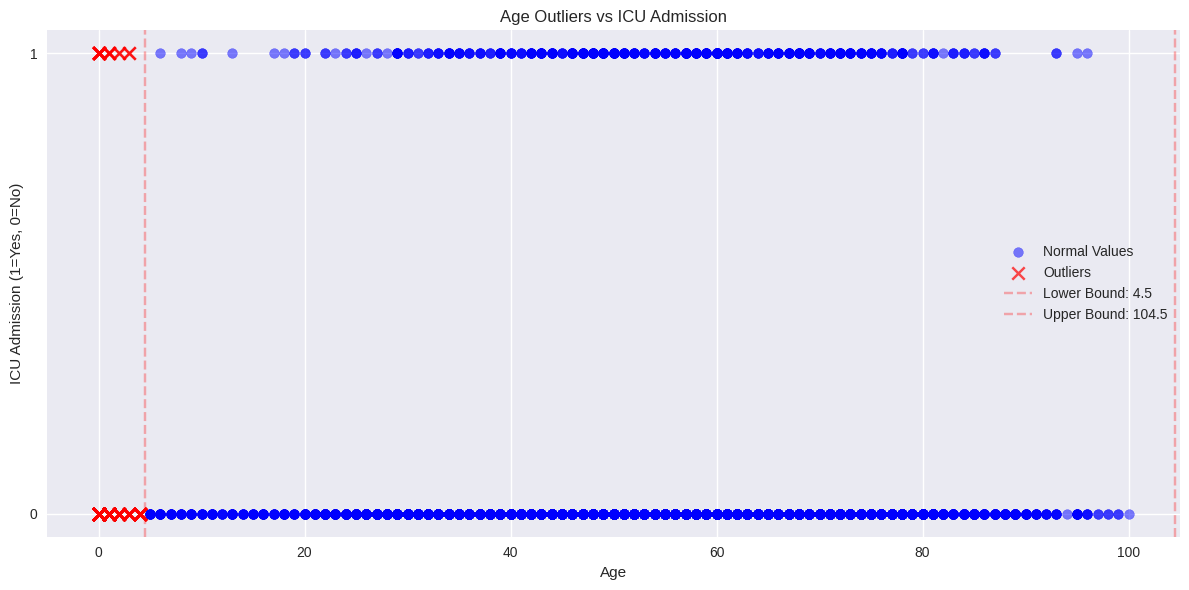


Outliers in AGE column: 5913 (3.12% of data)
Outlier boundaries: Lower = 4.50, Upper = 104.50
Age range before capping: 0 to 118
Outliers capped in AGE column (instead of removal).
Age range after capping: 4.5 to 104.5
Dataset shape after outlier handling: (189586, 17)


In [11]:
# Identify and count outliers
outliers = df_cleaned_no_nulls[(df_cleaned_no_nulls['AGE'] < lower_bound) |
                             (df_cleaned_no_nulls['AGE'] > upper_bound)]
outlier_count = len(outliers)
outlier_percentage = (outlier_count / len(df_cleaned_no_nulls)) * 100

# Create another visualization - Scatter plot showing outliers vs ICU admission
plt.figure(figsize=(12, 6))

# Sample a smaller subset for clearer visualization if dataset is large
n_samples = min(5000, len(df_cleaned_no_nulls))
sample_data = df_cleaned_no_nulls.sample(n=n_samples, random_state=42)

# Define outlier mask
is_outlier = (sample_data['AGE'] < lower_bound) | (sample_data['AGE'] > upper_bound)

# Plot non-outliers
plt.scatter(
    sample_data.loc[~is_outlier, 'AGE'],
    sample_data.loc[~is_outlier, 'ICU'],
    alpha=0.5,
    label='Normal Values',
    c='blue'
)

# Plot outliers
plt.scatter(
    sample_data.loc[is_outlier, 'AGE'],
    sample_data.loc[is_outlier, 'ICU'],
    alpha=0.7,
    label='Outliers',
    c='red',
    marker='x',
    s=80
)

# Add reference lines for outlier boundaries
plt.axvline(x=lower_bound, color='red', linestyle='--', alpha=0.3, label=f'Lower Bound: {lower_bound:.1f}')
plt.axvline(x=upper_bound, color='red', linestyle='--', alpha=0.3, label=f'Upper Bound: {upper_bound:.1f}')

plt.title('Age Outliers vs ICU Admission')
plt.xlabel('Age')
plt.ylabel('ICU Admission (1=Yes, 0=No)')
plt.yticks([0, 1])
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

print(f"\nOutliers in AGE column: {outlier_count} ({outlier_percentage:.2f}% of data)")
print(f"Outlier boundaries: Lower = {lower_bound:.2f}, Upper = {upper_bound:.2f}")
print(f"Age range before capping: {df_cleaned_no_nulls['AGE'].min()} to {df_cleaned_no_nulls['AGE'].max()}")
print(f"Outliers capped in AGE column (instead of removal).")
print(f"Age range after capping: {df_no_outliers['AGE'].min()} to {df_no_outliers['AGE'].max()}")
print(f"Dataset shape after outlier handling: {df_no_outliers.shape}")


Normalized feature ranges:
              AGE  CLASIFFICATION_FINAL
count  189586.000            189586.000
mean        0.487                 0.590
std         0.192                 0.316
min         0.000                 0.000
25%         0.375                 0.333
50%         0.505                 0.333
75%         0.625                 1.000
max         1.000                 1.000

Final preprocessed dataset shape: (189586, 17)


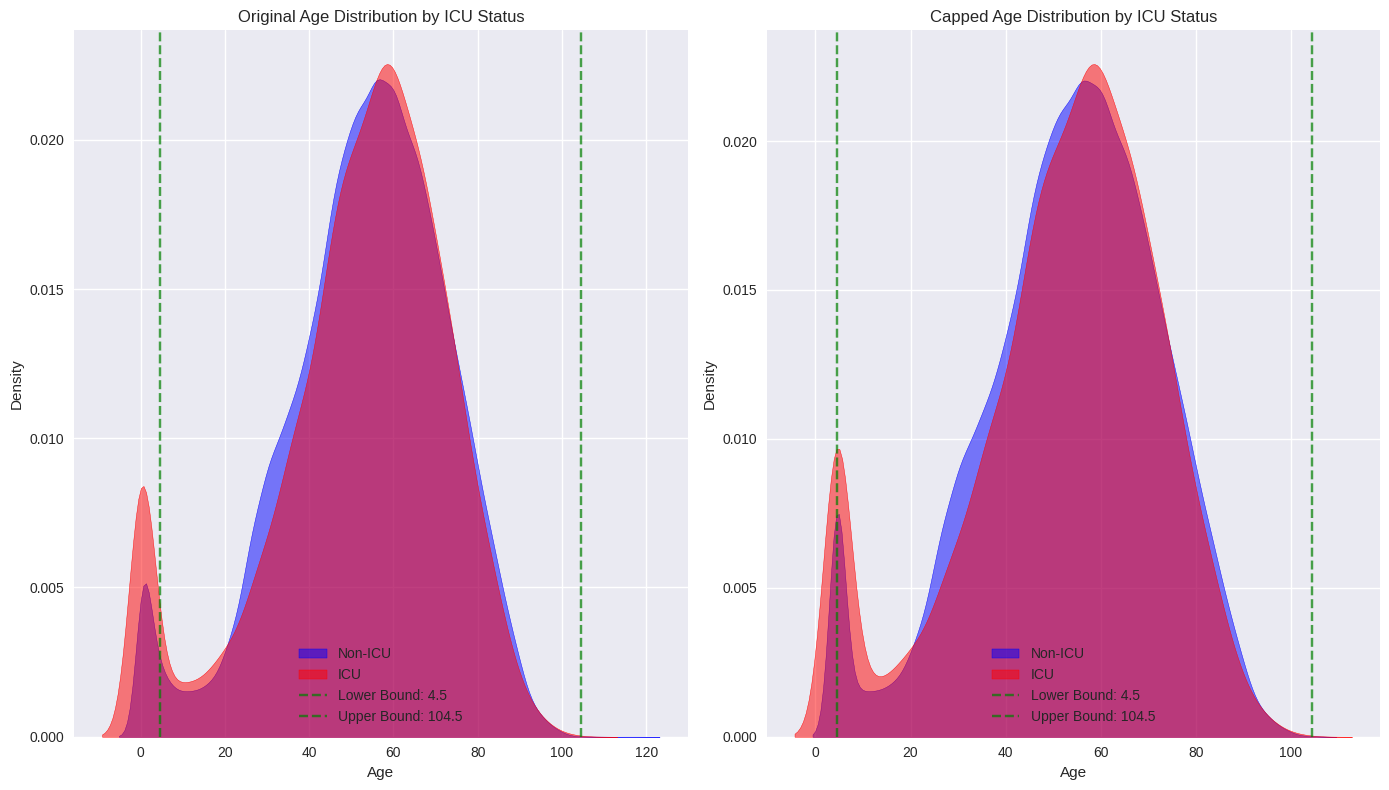

In [12]:
# Normalize features where applicable
df_scaled = df_no_outliers.copy()

# Check if we have data to scale
if df_scaled.shape[0] > 0:
    # Apply Min-Max scaling to AGE and CLASIFFICATION_FINAL
    scale_cols = ['AGE', 'CLASIFFICATION_FINAL']
    scaler = MinMaxScaler()

    # Check if both columns exist and contain data
    if all(col in df_scaled.columns for col in scale_cols) and not df_scaled[scale_cols].empty:
        df_scaled[scale_cols] = scaler.fit_transform(df_scaled[scale_cols])
        print(f"\nNormalized feature ranges:")
        print(df_scaled[scale_cols].describe().round(3))
    else:
        print(f"\nWarning: Could not scale features - some columns missing or empty")
else:
    print(f"\nWarning: No data available for scaling")

print(f"\nFinal preprocessed dataset shape: {df_scaled.shape}")

# Additional visualization: Compare original vs. capped age distributions with ICU rate
plt.figure(figsize=(14, 8))

# Original Age Distribution by ICU Status
plt.subplot(1, 2, 1)
for icu_status, color, label in zip([0, 1], ['blue', 'red'], ['Non-ICU', 'ICU']):
    subset = df_before_outlier_handling[df_before_outlier_handling['ICU'] == icu_status]
    sns.kdeplot(subset['AGE'], fill=True, alpha=0.5, label=label, color=color)

plt.title('Original Age Distribution by ICU Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.axvline(x=lower_bound, color='green', linestyle='--', alpha=0.7, label=f'Lower Bound: {lower_bound:.1f}')
plt.axvline(x=upper_bound, color='green', linestyle='--', alpha=0.7, label=f'Upper Bound: {upper_bound:.1f}')
plt.legend()

# Capped Age Distribution by ICU Status
plt.subplot(1, 2, 2)
for icu_status, color, label in zip([0, 1], ['blue', 'red'], ['Non-ICU', 'ICU']):
    subset = df_no_outliers[df_no_outliers['ICU'] == icu_status]
    sns.kdeplot(subset['AGE'], fill=True, alpha=0.5, label=label, color=color)

plt.title('Capped Age Distribution by ICU Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.axvline(x=lower_bound, color='green', linestyle='--', alpha=0.7, label=f'Lower Bound: {lower_bound:.1f}')
plt.axvline(x=upper_bound, color='green', linestyle='--', alpha=0.7, label=f'Upper Bound: {upper_bound:.1f}')
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

###3. DATA VISUALIZATION

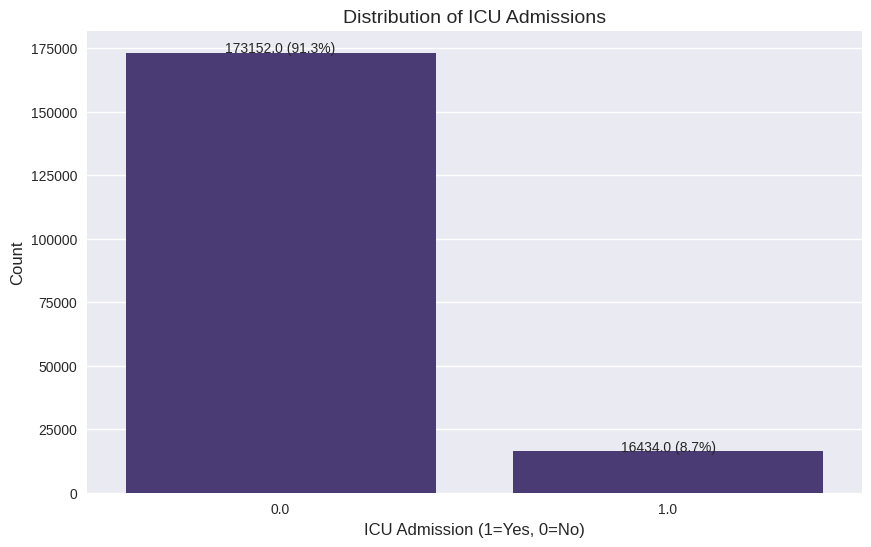

In [14]:
# Create a directory for saving plots if it doesn't exist
import os
if not os.path.exists('plots'):
    os.makedirs('plots')

# Target variable distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='ICU', data=df_scaled)
plt.title('Distribution of ICU Admissions', fontsize=14)
plt.xlabel('ICU Admission (1=Yes, 0=No)', fontsize=12)
plt.ylabel('Count', fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.1,
            f'{height} ({height/len(df_scaled)*100:.1f}%)',
            ha="center")
plt.show()
plt.close()

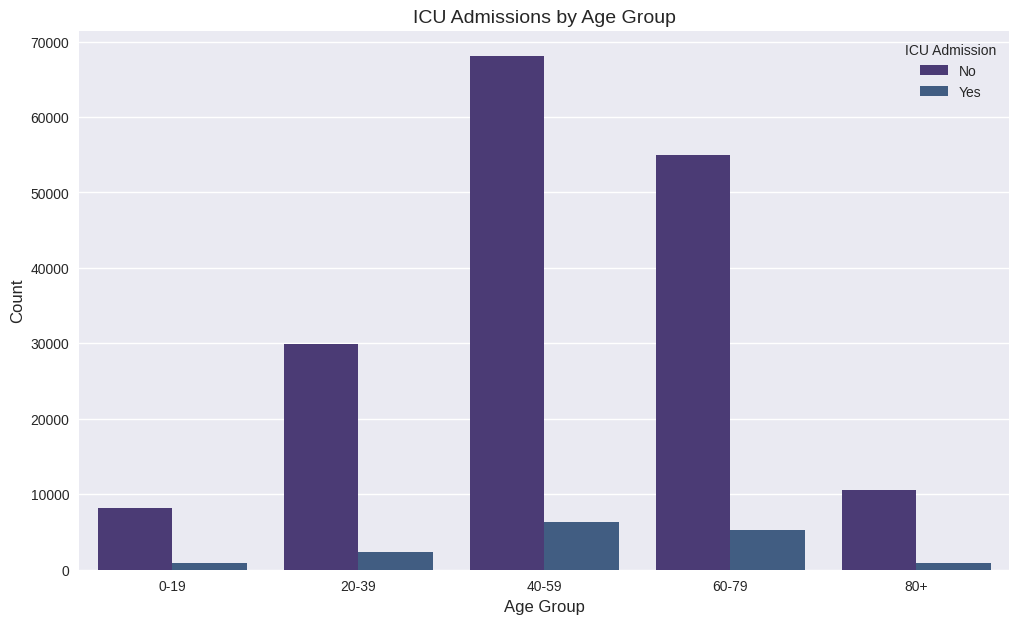

In [15]:
# ICU cases by age group
plt.figure(figsize=(12, 7))
sns.countplot(x='AGE_GROUP', hue='ICU', data=df_scaled)
plt.title('ICU Admissions by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='ICU Admission', labels=['No', 'Yes'])
plt.show()
plt.close()

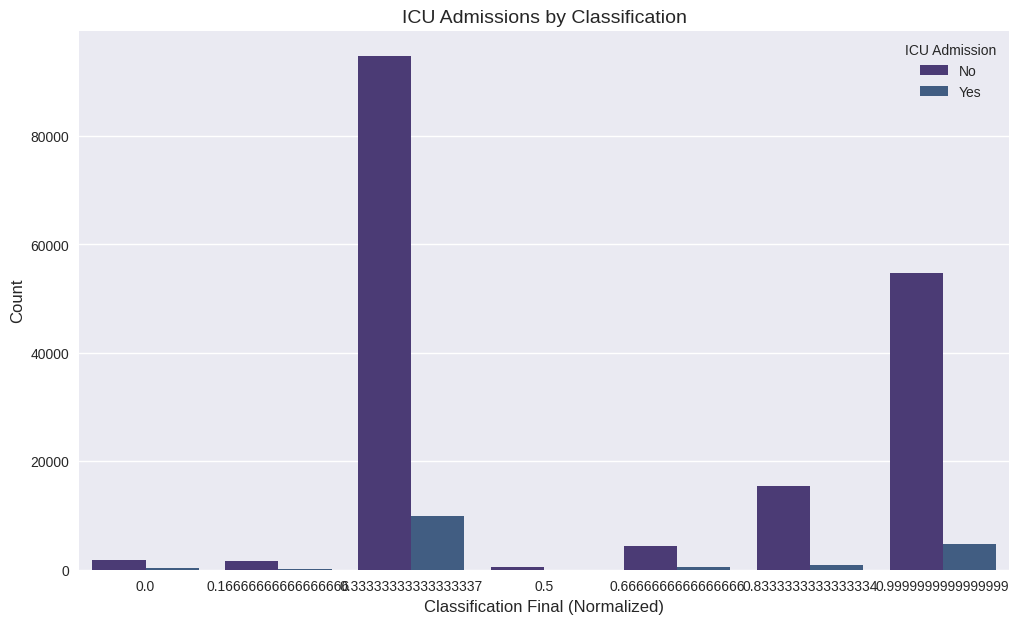

In [16]:
# ICU cases by CLASIFFICATION_FINAL
plt.figure(figsize=(12, 7))
sns.countplot(x='CLASIFFICATION_FINAL', hue='ICU', data=df_scaled)
plt.title('ICU Admissions by Classification', fontsize=14)
plt.xlabel('Classification Final (Normalized)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='ICU Admission', labels=['No', 'Yes'])
plt.show()
plt.close()

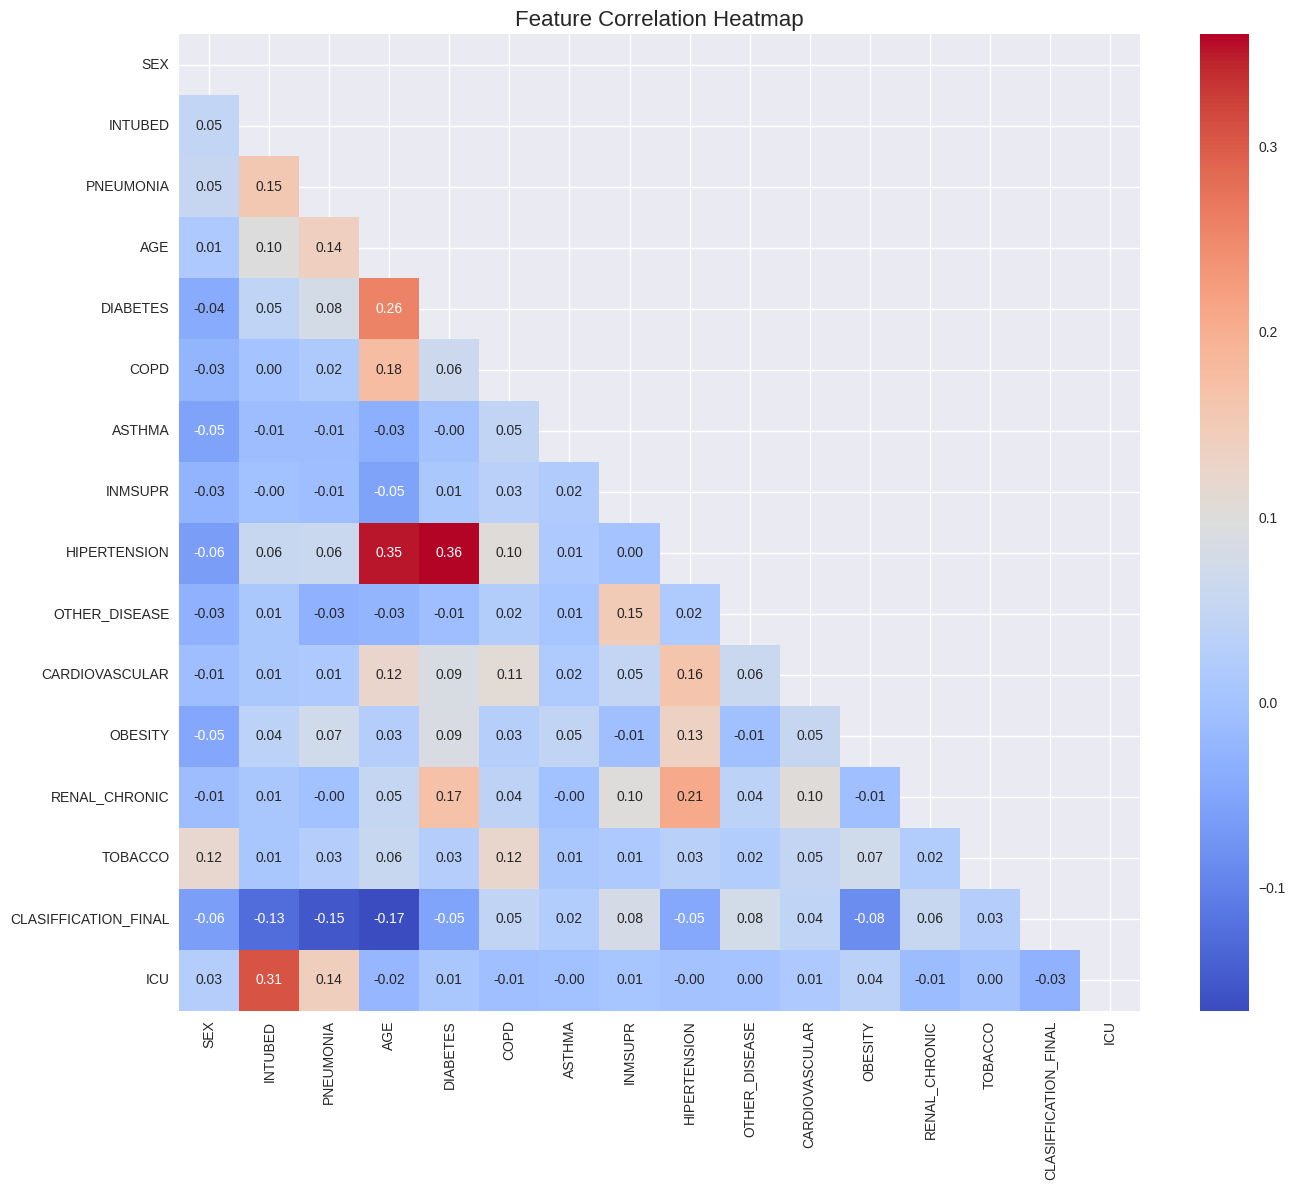

In [17]:
# Correlation heatmap
plt.figure(figsize=(14, 12))
corr = df_scaled.drop(columns=['AGE_GROUP']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

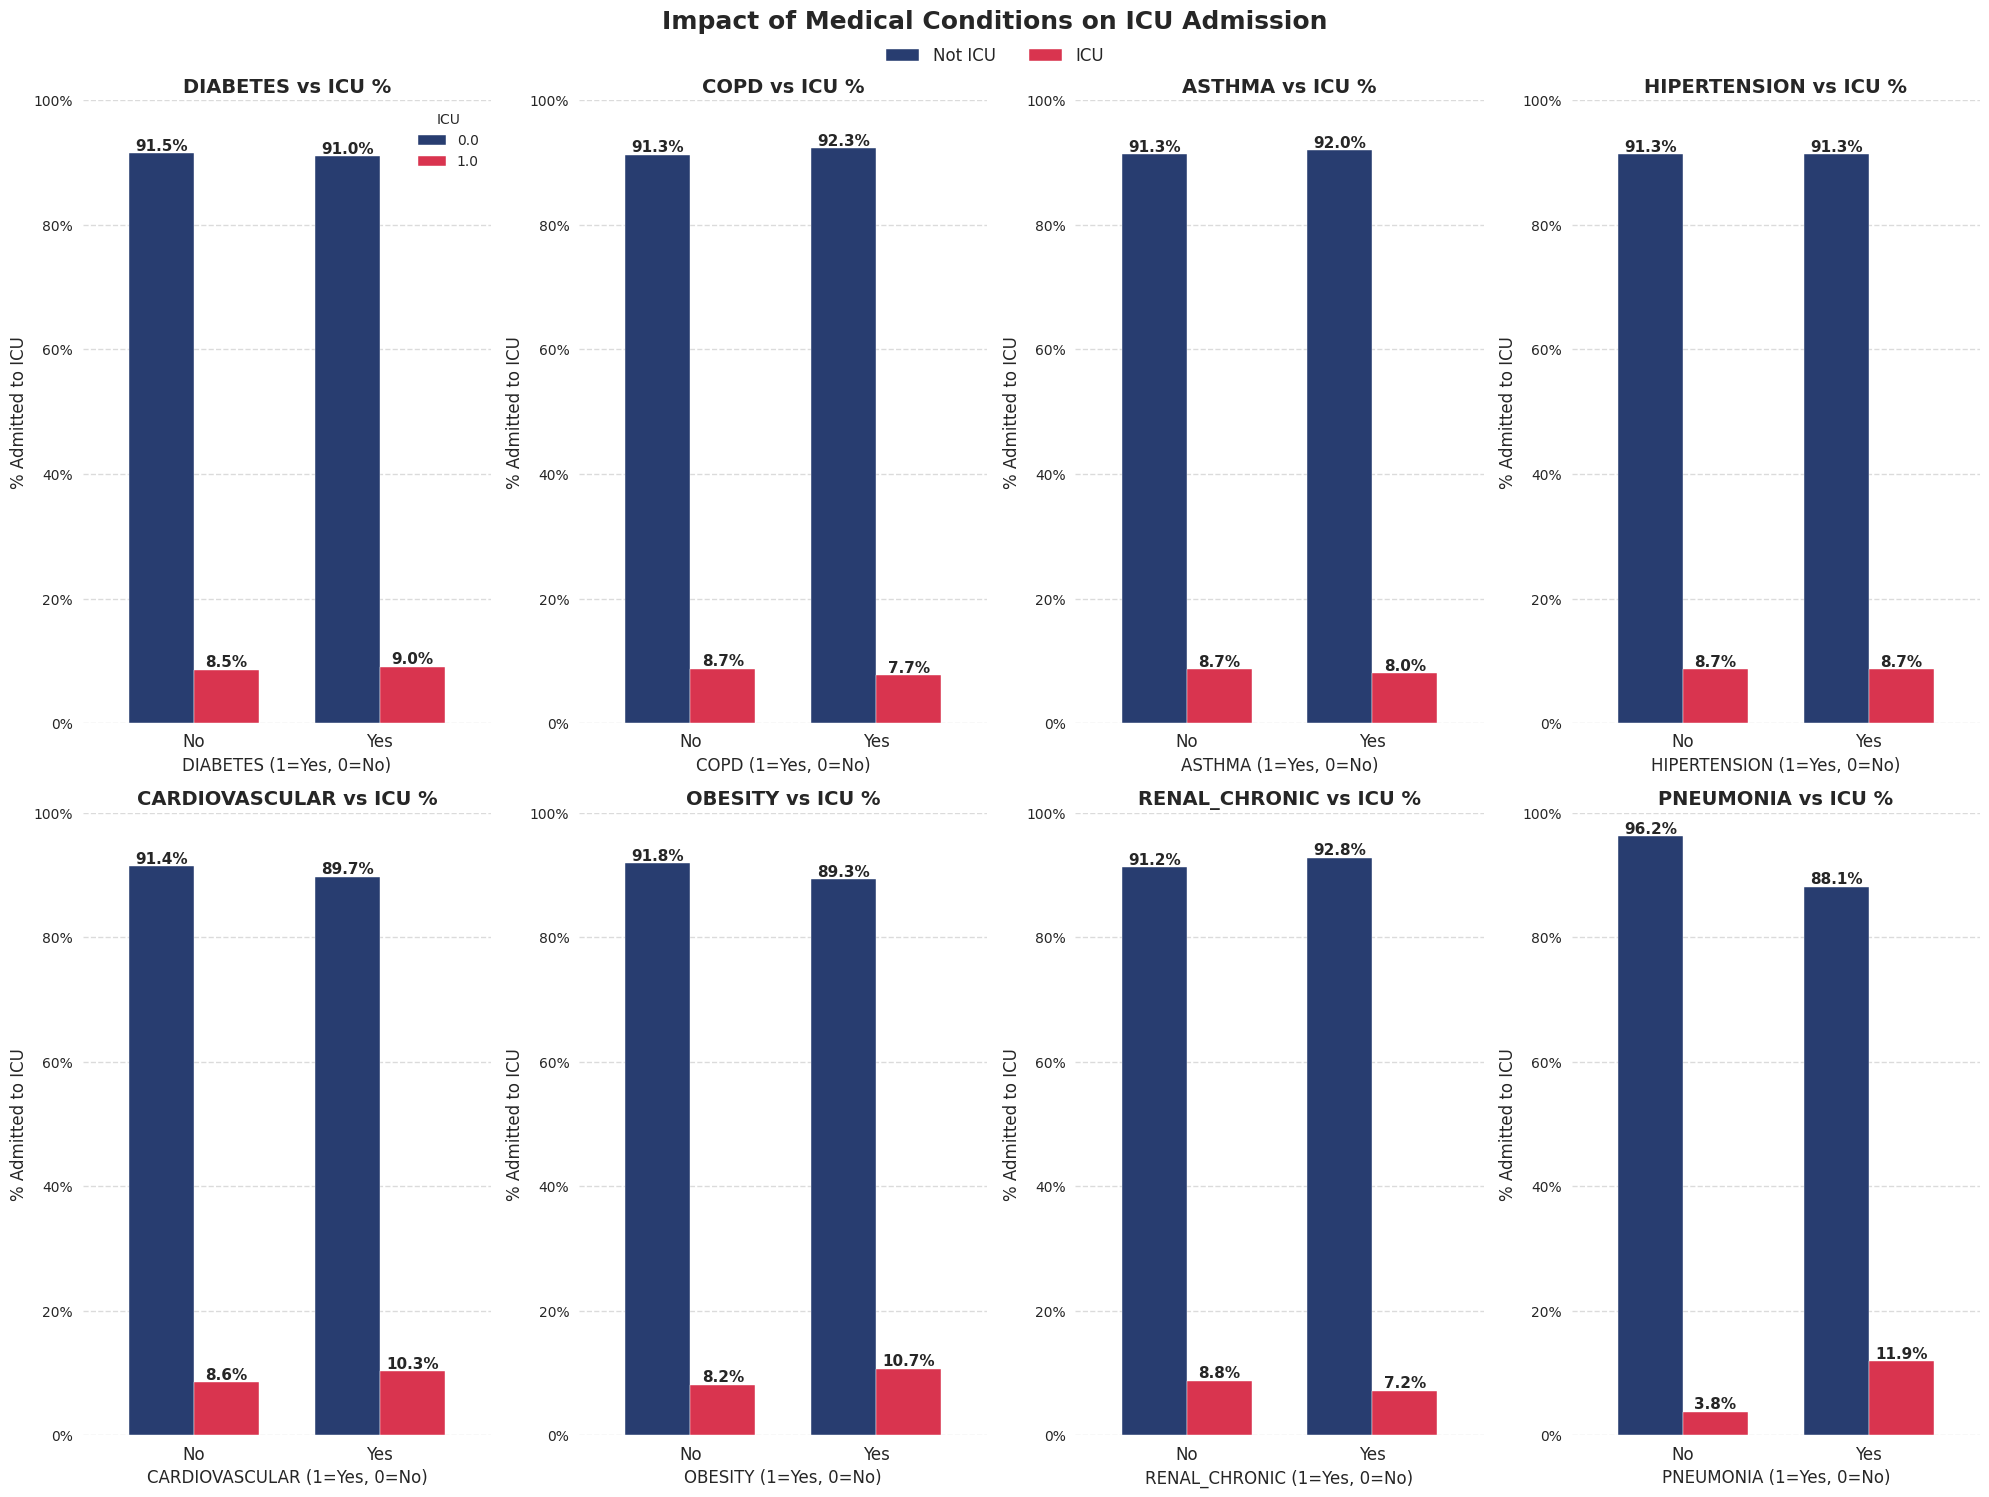

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(20, 15))

medical_conditions = [
    'DIABETES', 'COPD', 'ASTHMA', 'HIPERTENSION',
    'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'PNEUMONIA'
]
colors = ['#283D70', '#D9344F']

for i, condition in enumerate(medical_conditions, 1):
    ax = plt.subplot(2, 4, i)
    cross_tab = pd.crosstab(
        df_scaled[condition],
        df_scaled['ICU'],
        normalize='index'
    ) * 100

    if 0 not in cross_tab.columns:
        cross_tab[0] = 0
    if 1 not in cross_tab.columns:
        cross_tab[1] = 0
    cross_tab = cross_tab.sort_index(axis=1)

    bars = cross_tab.plot(
        kind='bar',
        ax=ax,
        color=colors,
        width=0.7,
        legend=i == 1
    )

    ax.get_xaxis().set_visible(True)

    plt.title(f'{condition} vs ICU %', fontsize=14, fontweight='bold')
    plt.xlabel(f'{condition} (1=Yes, 0=No)', fontsize=12)
    plt.ylabel('% Admitted to ICU', fontsize=12)

    plt.xticks([0, 1], ['No', 'Yes'], rotation=0, fontsize=12)

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=11, fontweight='bold')

    plt.ylim(0, 100)

    if len(ax.get_yticklabels(minor=True)) > 0:
        ax.yaxis.set_ticklabels([])

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.grid(axis='x', visible=False)

handles, labels = ax.get_legend_handles_labels()
plt.figlegend(
    handles,
    ['Not ICU', 'ICU'],
    loc='upper center',
    ncol=2,
    bbox_to_anchor=(0.5, 0.98),
    fontsize=12
)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.suptitle('Impact of Medical Conditions on ICU Admission',
             fontsize=18, fontweight='bold', y=0.995)

plt.show()
plt.close()

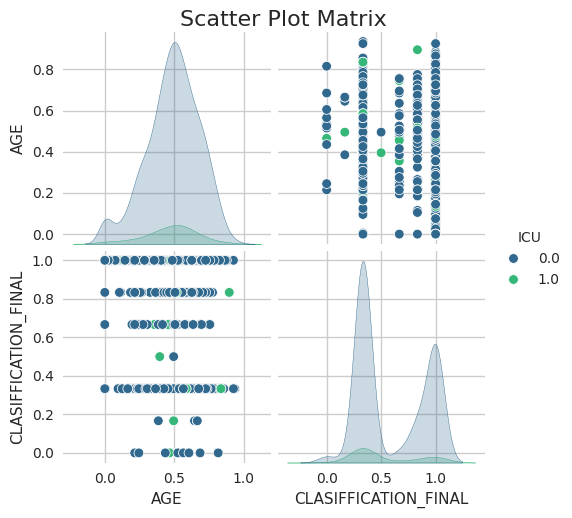

In [23]:
# Scatter plot matrix for key numerical features
scatter_features = ['AGE', 'CLASIFFICATION_FINAL', 'ICU']
scatter_df = df_scaled[scatter_features].sample(1000)
sns.pairplot(scatter_df, hue='ICU', palette='viridis')
plt.suptitle('Scatter Plot Matrix', y=1.02, fontsize=16)
plt.show()
plt.close()


###4. MODEL BUILDING AND EVALUATION

In [25]:
# Select predictors for model building
predictors = [
    'AGE',
    'SEX',
    'INTUBED',
    'PNEUMONIA',
    'DIABETES',
    'COPD',
    'ASTHMA',
    'INMSUPR',
    'HIPERTENSION',
    'OTHER_DISEASE',
    'CARDIOVASCULAR',
    'OBESITY',
    'RENAL_CHRONIC',
    'TOBACCO',
    'CLASIFFICATION_FINAL'
]

# Define features (X) and target (y)
X = df_scaled[predictors]
y = df_scaled['ICU']

# Check for NaN values in the target
nan_count_y = y.isna().sum()
if nan_count_y > 0:
    print(f"Found {nan_count_y} NaN values in the target variable. Removing these samples.")
    # Get indices of non-NaN values
    valid_indices = ~y.isna()
    X = X[valid_indices]
    y = y[valid_indices]

# Output dimensions and class distribution
print("Features shape after removing NaN targets:", X.shape)
print("\nTarget distribution:")
print(y.value_counts())
print(f"Percentage of positive class (ICU=1): {y.mean()*100:.2f}%")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Features shape after removing NaN targets: (189586, 15)

Target distribution:
ICU
0.0    173152
1.0     16434
Name: count, dtype: int64
Percentage of positive class (ICU=1): 8.67%

Training set: 151668 samples
Test set: 37918 samples


 UNBALANCED MODEL

Average F1 Score from 5-Fold CV: 0.0078

Classification Report (Unbalanced Model):
              precision    recall  f1-score   support

Not Admitted       0.91      1.00      0.95     34631
    Admitted       0.65      0.00      0.01      3287

    accuracy                           0.91     37918
   macro avg       0.78      0.50      0.48     37918
weighted avg       0.89      0.91      0.87     37918


Confusion Matrix:
[[34624     7]
 [ 3274    13]]

Performance Metrics (Unbalanced Model):
ROC-AUC Score: 0.7706
Precision (Admitted): 0.6500
Recall (Admitted): 0.0040
F1 Score (Admitted): 0.0079


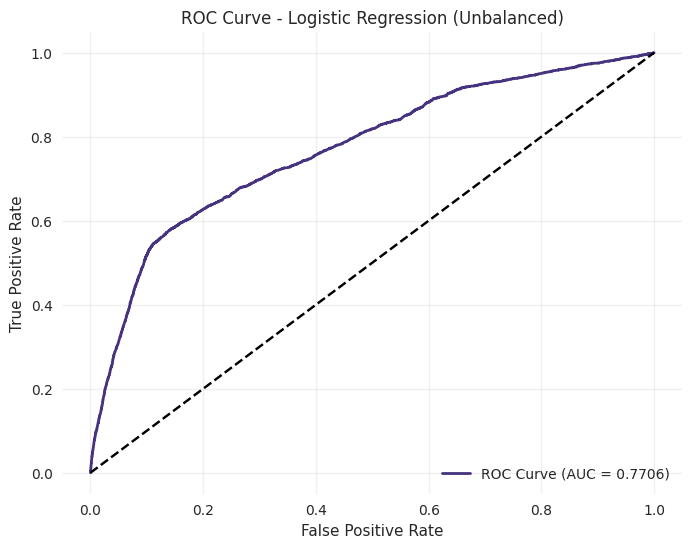

In [26]:
# Initialize logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Cross-validation for F1-score
f1_cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1')
print(f"Average F1 Score from 5-Fold CV: {f1_cv_scores.mean():.4f}")

# Train the model
log_reg.fit(X_train, y_train)

# Predict on test set
y_pred_unbalanced = log_reg.predict(X_test)
y_prob_unbalanced = log_reg.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\nClassification Report (Unbalanced Model):")
print(classification_report(y_test, y_pred_unbalanced, target_names=['Not Admitted', 'Admitted']))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred_unbalanced)
print(conf_matrix)

# Store metrics for later comparison
roc_auc_unbalanced = roc_auc_score(y_test, y_prob_unbalanced)
precision_unbalanced = precision_score(y_test, y_pred_unbalanced)
recall_unbalanced = recall_score(y_test, y_pred_unbalanced)
f1_unbalanced = f1_score(y_test, y_pred_unbalanced)

print(f"\nPerformance Metrics (Unbalanced Model):")
print(f"ROC-AUC Score: {roc_auc_unbalanced:.4f}")
print(f"Precision (Admitted): {precision_unbalanced:.4f}")
print(f"Recall (Admitted): {recall_unbalanced:.4f}")
print(f"F1 Score (Admitted): {f1_unbalanced:.4f}")

# Plot ROC curve for unbalanced model
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob_unbalanced)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_unbalanced:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Unbalanced)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()
plt.close()

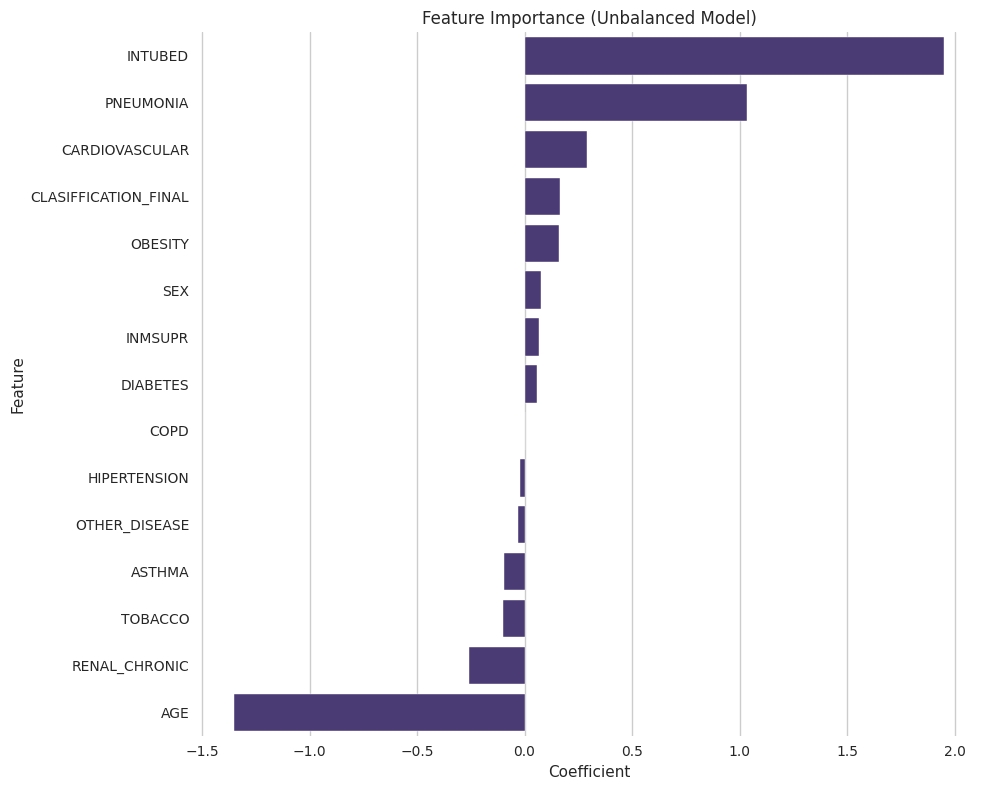

In [27]:
# Feature importance (coefficients for logistic regression)
feature_importance = pd.DataFrame({
    'Feature': predictors,
    'Coefficient': log_reg.coef_[0]
})
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance (Unbalanced Model)')
plt.tight_layout()
plt.show()
plt.close()


BALANCED MODEL USING SMOTE

Class distribution before SMOTE:
ICU
0.0    138521
1.0     13147
Name: count, dtype: int64

Class distribution after SMOTE:
ICU
0.0    138521
1.0    138521
Name: count, dtype: int64

Classification Report (SMOTE Balanced Model):
              precision    recall  f1-score   support

Not Admitted       0.96      0.82      0.88     34631
    Admitted       0.25      0.61      0.35      3287

    accuracy                           0.80     37918
   macro avg       0.60      0.72      0.62     37918
weighted avg       0.90      0.80      0.84     37918


Confusion Matrix:
[[28499  6132]
 [ 1290  1997]]

Performance Metrics (SMOTE Balanced Model):
ROC-AUC Score: 0.7699
Precision (Admitted): 0.2457
Recall (Admitted): 0.6075
F1 Score (Admitted): 0.3499


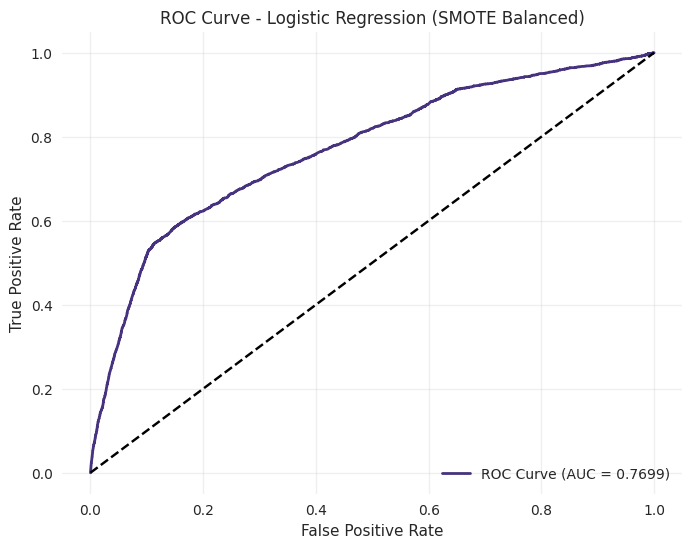

In [28]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_bal).value_counts())

# Train model with balanced data
model_balanced = LogisticRegression(max_iter=1000, random_state=42)
model_balanced.fit(X_train_bal, y_train_bal)

# Predict on test set
y_pred_balanced = model_balanced.predict(X_test)
y_prob_balanced = model_balanced.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\nClassification Report (SMOTE Balanced Model):")
print(classification_report(y_test, y_pred_balanced, target_names=['Not Admitted', 'Admitted']))

print("\nConfusion Matrix:")
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
print(conf_matrix_balanced)

# Calculate metrics
roc_auc_balanced = roc_auc_score(y_test, y_prob_balanced)
precision_balanced = precision_score(y_test, y_pred_balanced)
recall_balanced = recall_score(y_test, y_pred_balanced)
f1_balanced = f1_score(y_test, y_pred_balanced)

print(f"\nPerformance Metrics (SMOTE Balanced Model):")
print(f"ROC-AUC Score: {roc_auc_balanced:.4f}")
print(f"Precision (Admitted): {precision_balanced:.4f}")
print(f"Recall (Admitted): {recall_balanced:.4f}")
print(f"F1 Score (Admitted): {f1_balanced:.4f}")

# Plot ROC curve for balanced model
plt.figure(figsize=(8, 6))
fpr_bal, tpr_bal, _ = roc_curve(y_test, y_prob_balanced)
plt.plot(fpr_bal, tpr_bal, label=f'ROC Curve (AUC = {roc_auc_balanced:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (SMOTE Balanced)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()
plt.close()

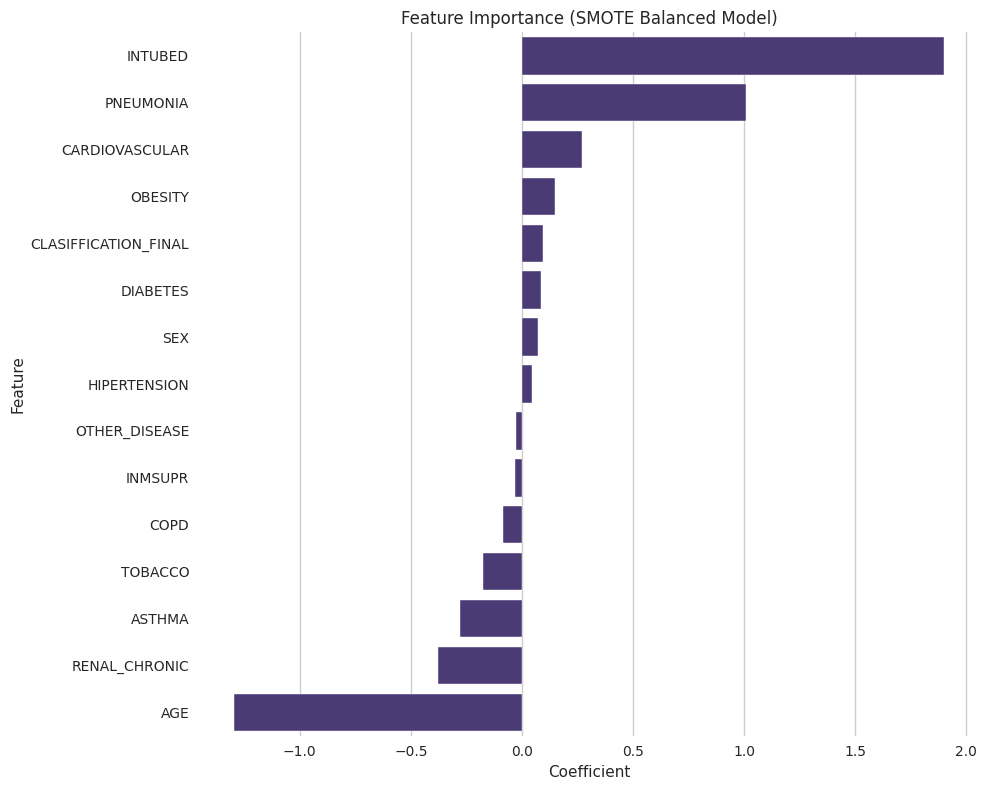

In [29]:
# Feature importance (coefficients) for balanced model
feature_importance_balanced = pd.DataFrame({
    'Feature': predictors,
    'Coefficient': model_balanced.coef_[0]
})
feature_importance_balanced = feature_importance_balanced.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance_balanced)
plt.title('Feature Importance (SMOTE Balanced Model)')
plt.tight_layout()
plt.show()
plt.close()

MODEL COMPARISON

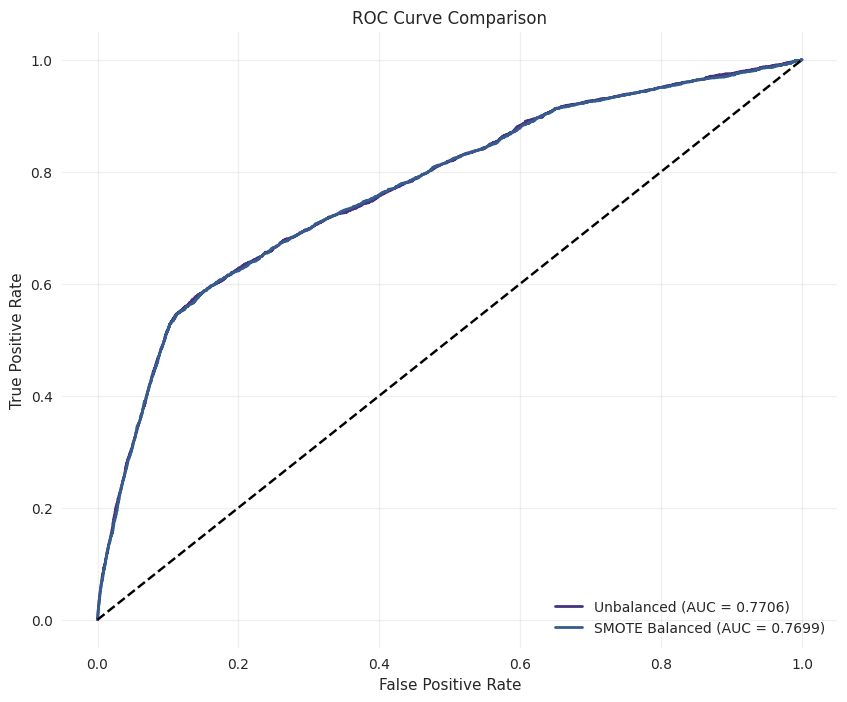

In [30]:
# Compare ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Unbalanced (AUC = {roc_auc_unbalanced:.4f})', linewidth=2)
plt.plot(fpr_bal, tpr_bal, label=f'SMOTE Balanced (AUC = {roc_auc_balanced:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()
plt.close()

In [31]:
# Summarize model comparison
print("\nModel Comparison (Unbalanced vs SMOTE Balanced)")
print("-" * 50)
print(f"Unbalanced Model - AUC: {roc_auc_unbalanced:.4f}, F1: {f1_unbalanced:.4f}, Precision: {precision_unbalanced:.4f}, Recall: {recall_unbalanced:.4f}")
print(f"Balanced Model   - AUC: {roc_auc_balanced:.4f}, F1: {f1_balanced:.4f}, Precision: {precision_balanced:.4f}, Recall: {recall_balanced:.4f}")

# Discussion on balanced vs unbalanced results
print("\nFindings:")
if f1_balanced > f1_unbalanced:
    print("- SMOTE balancing improved the F1 score, indicating better overall performance.")
else:
    print("- SMOTE balancing did not improve the F1 score.")

if recall_balanced > recall_unbalanced:
    print("- SMOTE balancing improved the recall, meaning we can identify more ICU cases.")
else:
    print("- SMOTE balancing did not improve recall for ICU cases.")

if precision_balanced < precision_unbalanced:
    print("- SMOTE balancing reduced precision, meaning more false positives.")
else:
    print("- SMOTE balancing did not reduce precision.")

print("\nPart 1 Analysis Complete!")


Model Comparison (Unbalanced vs SMOTE Balanced)
--------------------------------------------------
Unbalanced Model - AUC: 0.7706, F1: 0.0079, Precision: 0.6500, Recall: 0.0040
Balanced Model   - AUC: 0.7699, F1: 0.3499, Precision: 0.2457, Recall: 0.6075

Findings:
- SMOTE balancing improved the F1 score, indicating better overall performance.
- SMOTE balancing improved the recall, meaning we can identify more ICU cases.
- SMOTE balancing reduced precision, meaning more false positives.

Part 1 Analysis Complete!


##Part 2: Improved model with PySpark, K-Means Clustering, and Local Classifiers

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, silhouette_score
)
import warnings
warnings.filterwarnings('ignore')

# Initialize PySpark
from pyspark.sql import functions as fn
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, when
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, silhouette_score
)
import warnings
warnings.filterwarnings('ignore')

###1. INITIALIZE SPARK SESSION

In [36]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("COVID19-ICU-Prediction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print("Spark session created successfully")

Spark session created successfully


###2. LOAD AND PREPROCESS DATA WITH PYSPARK

In [37]:
# Load the dataset using Spark
df_spark = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/BigData 2025/Dataset.csv', header=True, inferSchema=True)
print(f"Original dataset shape: {df_spark.count()} rows, {len(df_spark.columns)} columns")

# Drop irrelevant columns
columns_to_drop = ['index', 'USMER', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'DATE_DIED']
df_spark = df_spark.drop(*columns_to_drop)
print(f"Dataset shape after dropping columns: {df_spark.count()} rows, {len(df_spark.columns)} columns")

# Handle missing values and convert data types
# First, convert string '?' to null values in all columns
for column in df_spark.columns:
    df_spark = df_spark.withColumn(column,
                                 when(col(column) == "?", None)
                                 .otherwise(col(column)))

# Convert binary columns from 1/2 to 1/0 encoding
binary_cols = [
    'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA',
    'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
    'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU'
]

for col_name in binary_cols:
    if col_name in df_spark.columns:
        df_spark = df_spark.withColumn(
            col_name,
            when(col(col_name) == 1, 1.0).otherwise(0.0)
        )

# Cast columns to proper types
numeric_cols = [c for c in df_spark.columns if c not in ['PREGNANT']]
for col_name in numeric_cols:
    df_spark = df_spark.withColumn(col_name, col(col_name).cast(DoubleType()))

# Impute missing values instead of dropping rows
numeric_imputer = Imputer(
    inputCols=numeric_cols,
    outputCols=numeric_cols,
    strategy='median'
)

# Fit and transform the imputer
imputer_model = numeric_imputer.fit(df_spark)
df_imputed = imputer_model.transform(df_spark)

print("\nMissing value counts after imputation:")
for col_name in df_imputed.columns:
    null_count = df_imputed.filter(col(col_name).isNull()).count()
    if null_count > 0:
        print(f"{col_name}: {null_count}")

# Prepare features for modeling
feature_cols = [
    'SEX', 'AGE', 'INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA',
    'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
    'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL'
]

# Create feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_features = assembler.transform(df_imputed)

# Scale features for better clustering and modeling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                        withStd=True, withMean=True)
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

print(f"\nFinal preprocessed PySpark dataframe ready for modeling")
print(f"Number of rows: {df_scaled.count()}")
print(f"Number of features: {len(feature_cols)}")

# Convert to pandas for visualization
pandas_df = df_imputed.toPandas()
print("\nTarget distribution:")
print(pandas_df['ICU'].value_counts())
print(f"Percentage of ICU cases: {pandas_df['ICU'].mean()*100:.2f}%")

Original dataset shape: 200031 rows, 22 columns
Dataset shape after dropping columns: 200031 rows, 17 columns

Missing value counts after imputation:

Final preprocessed PySpark dataframe ready for modeling
Number of rows: 200031
Number of features: 15

Target distribution:
ICU
0.0    183173
1.0     16858
Name: count, dtype: int64
Percentage of ICU cases: 8.43%


###3. IMPROVED CLASSIFICATION MODEL WITH PYSPARK

In [38]:
# Split data into training and testing sets
train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=42)
print(f"Training set: {train_data.count()} samples")
print(f"Test set: {test_data.count()} samples")

# Build an improved logistic regression model
lr = LogisticRegression(
    featuresCol="scaled_features",
    labelCol="ICU",
    maxIter=10,
    regParam=0.1,
    elasticNetParam=0.8,
    standardization=False,  # Already standardized
    threshold=0.5,
    family="binomial"
)

# Train the model
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model
binary_evaluator = BinaryClassificationEvaluator(
    labelCol="ICU",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = binary_evaluator.evaluate(predictions)

# Extract predictions to pandas for detailed metrics
pred_df = predictions.select("ICU", "prediction", "probability").toPandas()
y_test = pred_df["ICU"]
y_pred = pred_df["prediction"]
y_prob = np.array([prob[1] for prob in pred_df["probability"]])

# Global model (initial PySpark LogisticRegression)
print("\nPySpark Model Performance:")
print(f"AUC: {auc:.4f}")
y_test_sum = y_test.sum()
if y_test_sum > 0 and y_pred.sum() > 0:
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
else:
    print("Precision, Recall and F1 Score couldn't be calculated - model predicted all zeros")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Admitted", "Admitted"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Training set: 159968 samples
Test set: 40063 samples

PySpark Model Performance:
AUC: 0.7084
Precision, Recall and F1 Score couldn't be calculated - model predicted all zeros

Classification Report:
              precision    recall  f1-score   support

Not Admitted       0.91      1.00      0.96     36625
    Admitted       0.00      0.00      0.00      3438

    accuracy                           0.91     40063
   macro avg       0.46      0.50      0.48     40063
weighted avg       0.84      0.91      0.87     40063


Confusion Matrix:
[[36625     0]
 [ 3438     0]]


###4. OPTIMIZED K-MEANS CLUSTERING

Running optimized K-means clustering...
Using sampled dataset with 60137 rows for faster clustering
Evaluating k=2...
  WCSS for k=2: 816900.0723
Evaluating k=3...
  WCSS for k=3: 771104.3277
Evaluating k=4...
  WCSS for k=4: 722559.4528
Evaluating k=5...
  WCSS for k=5: 687652.5388
Evaluating k=6...
  WCSS for k=6: 648614.7221


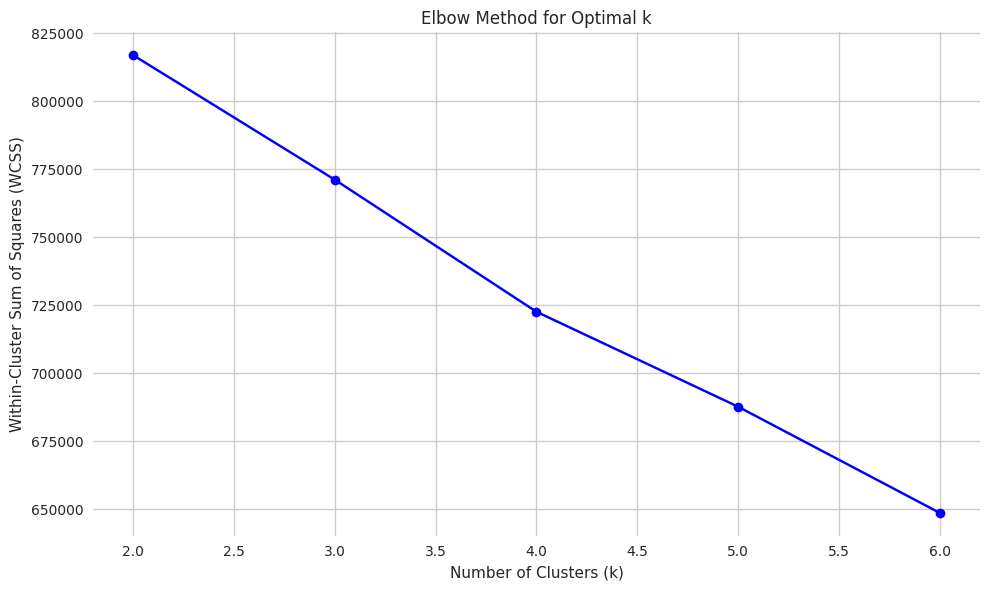

In [39]:
# Faster approach - use sample of data and focus on elbow method
print("Running optimized K-means clustering...")

# Sample the data to speed up processing (adjust fraction as needed)
df_sample = df_scaled.sample(False, fraction=0.3, seed=42)
print(f"Using sampled dataset with {df_sample.count()} rows for faster clustering")

# Evaluate fewer k values
k_values = range(2, 7)  # Reduced range
cost_values = []

# Calculate WCSS for different k values (skip silhouette for speed)
for k in k_values:
    print(f"Evaluating k={k}...")
    kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster", k=k, seed=42, maxIter=20)
    model = kmeans.fit(df_sample)
    cost_values.append(model.summary.trainingCost)
    print(f"  WCSS for k={k}: {model.summary.trainingCost:.4f}")

# Plot elbow method
plt.figure(figsize=(10, 6))
plt.plot(k_values, cost_values, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

In [40]:
deltas = np.diff(cost_values)
delta_deltas = np.diff(deltas)
optimal_k_idx = np.argmax(np.abs(delta_deltas)) + 1
optimal_k = k_values[optimal_k_idx]
print(f"\nDetected optimal number of clusters: k={optimal_k}")

#  Apply K-Means with optimal k to full dataset
print(f"\nApplying K-means clustering with k={optimal_k} to the full dataset...")
kmeans_final = KMeans(
    featuresCol="scaled_features",
    predictionCol="cluster",
    k=optimal_k,
    seed=42,
    maxIter=20
)
kmeans_model = kmeans_final.fit(df_scaled)
clustered_data = kmeans_model.transform(df_scaled)

# Analyze cluster sizes
cluster_distribution = clustered_data.groupBy("cluster").count().orderBy("cluster")
print("\nCluster distribution:")
cluster_distribution.show()

# Calculate ICU rate by cluster
icu_by_cluster = clustered_data.groupBy("cluster").agg(
    fn.mean("ICU").alias("icu_rate"),
    fn.count("*").alias("count")
).orderBy(fn.desc("icu_rate"))

print("\nICU rates by cluster:")
icu_by_cluster.show()

#  Quickly move to local classifiers without extensive visualization
print("\nMoving to cluster-based classification...")


Detected optimal number of clusters: k=4

Applying K-means clustering with k=4 to the full dataset...

Cluster distribution:
+-------+------+
|cluster| count|
+-------+------+
|      0| 11731|
|      1|105229|
|      2| 15434|
|      3| 67637|
+-------+------+


ICU rates by cluster:
+-------+-------------------+------+
|cluster|           icu_rate| count|
+-------+-------------------+------+
|      3|0.09493324659579816| 67637|
|      2|0.08390566282234029| 15434|
|      1|0.07901814138688004|105229|
|      0|0.07049697383002301| 11731|
+-------+-------------------+------+


Moving to cluster-based classification...


###5. CLUSTER-BASED CLASSIFICATION

In [41]:
# Add cluster information to the original PySpark dataframe
df_with_clusters = clustered_data.select("ICU", "scaled_features", "cluster")

# Split data by clusters for local classifiers
train_with_clusters, test_with_clusters = df_with_clusters.randomSplit([0.8, 0.2], seed=42)

# Build local classifiers for each cluster
cluster_models = {}
cluster_predictions = []

for cluster_id in range(optimal_k):
    print(f"\nTraining local classifier for Cluster {cluster_id}")

    # Filter training data for this cluster
    cluster_train = train_with_clusters.filter(col("cluster") == cluster_id)
    cluster_test = test_with_clusters.filter(col("cluster") == cluster_id)

    # Check if we have enough data in this cluster
    train_count = cluster_train.count()
    test_count = cluster_test.count()
    print(f"  Training samples: {train_count}, Test samples: {test_count}")

    if train_count < 20 or test_count < 10:
        print(f"  Not enough data for Cluster {cluster_id}, using global model instead")
        continue

    # Train a logistic regression model for this cluster
    cluster_lr = LogisticRegression(
        featuresCol="scaled_features",
        labelCol="ICU",
        maxIter=10,
        regParam=0.1
    )

    # Try to train model, handle potential errors
    try:
        cluster_model = cluster_lr.fit(cluster_train)
        cluster_models[cluster_id] = cluster_model

        # Make predictions on test data for this cluster
        cluster_preds = cluster_model.transform(cluster_test)
        cluster_predictions.append(cluster_preds)

        # Evaluate model for this cluster
        cluster_auc = binary_evaluator.evaluate(cluster_preds)
        print(f"  Local model AUC for Cluster {cluster_id}: {cluster_auc:.4f}")

    except Exception as e:
        print(f"  Error training model for Cluster {cluster_id}: {e}")
        print(f"  Using global model for this cluster")

#  Use global model for clusters without local models
# Identify clusters without local models
missing_clusters = [c for c in range(optimal_k) if c not in cluster_models]
if missing_clusters:
    print(f"\nUsing global model for clusters: {missing_clusters}")

    # Filter test data for these clusters
    missing_clusters_test = test_with_clusters.filter(
        col("cluster").isin(missing_clusters)
    )

    # Use global model for predictions
    global_preds = lr_model.transform(missing_clusters_test)
    cluster_predictions.append(global_preds)

# Combine predictions from all local models
combined_predictions = None
for preds in cluster_predictions:
    if combined_predictions is None:
        combined_predictions = preds
    else:
        combined_predictions = combined_predictions.union(preds)

# Evaluate the combined cluster-based models
if combined_predictions and combined_predictions.count() > 0:
    cluster_based_auc = binary_evaluator.evaluate(combined_predictions)

    # Extract predictions to pandas for detailed metrics
    cb_pred_df = combined_predictions.select("ICU", "prediction", "probability").toPandas()
    cb_y_test = cb_pred_df["ICU"]
    cb_y_pred = cb_pred_df["prediction"]
    cb_y_prob = np.array([prob[1] for prob in cb_pred_df["probability"]])

    print("\nCluster-Based Model Performance:")
    print(f"AUC: {cluster_based_auc:.4f}")

    if cb_y_pred.sum() > 0:
        print(f"Precision: {precision_score(cb_y_test, cb_y_pred):.4f}")
        print(f"Recall: {recall_score(cb_y_test, cb_y_pred):.4f}")
        print(f"F1 Score: {f1_score(cb_y_test, cb_y_pred):.4f}")
    else:
        print("Precision: 0.0000")
        print("Recall: 0.0000")
        print("F1 Score: 0.0000")

    print("\nClassification Report:")
    print(classification_report(cb_y_test, cb_y_pred, target_names=["Not Admitted", "Admitted"]))

    print("\nConfusion Matrix:")
    print(confusion_matrix(cb_y_test, cb_y_pred))
else:
    print("\nNo predictions available from cluster-based models.")


Training local classifier for Cluster 0
  Training samples: 9417, Test samples: 2314
  Local model AUC for Cluster 0: 0.7619

Training local classifier for Cluster 1
  Training samples: 84138, Test samples: 21091
  Local model AUC for Cluster 1: 0.7692

Training local classifier for Cluster 2
  Training samples: 12325, Test samples: 3109
  Local model AUC for Cluster 2: 0.8005

Training local classifier for Cluster 3
  Training samples: 54088, Test samples: 13549
  Local model AUC for Cluster 3: 0.7472

Cluster-Based Model Performance:
AUC: 0.7646
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Classification Report:
              precision    recall  f1-score   support

Not Admitted       0.91      1.00      0.96     36628
    Admitted       0.00      0.00      0.00      3435

    accuracy                           0.91     40063
   macro avg       0.46      0.50      0.48     40063
weighted avg       0.84      0.91      0.87     40063


Confusion Matrix:
[[36628     0]
 [ 3435   

###6. BALANCED CLUSTER-BASED APPROACH

In [42]:
# Convert clustered data to pandas for SMOTE balancing
clusters_pd = clustered_data.select("cluster", "ICU", "scaled_features").toPandas()

# Function to extract features from vector column - FIXED VERSION
def extract_features(row):
    """Extract feature array from Spark vector"""
    try:
        # Try to convert a Spark Vector to array
        return row.toArray()
    except AttributeError:
        # Already a numpy array, return as is
        return row

# Extract scaled features from the vector column
clusters_pd['features_array'] = clusters_pd['scaled_features'].apply(extract_features)

# Function to apply SMOTE to a single cluster
def balance_cluster(cluster_data):
    """Apply SMOTE to balance a specific cluster's data"""
    from imblearn.over_sampling import SMOTE

    # Extract features and target
    X = np.stack(cluster_data['features_array'].values)
    y = cluster_data['ICU'].values

    # Check if we have enough samples of each class
    class_counts = np.bincount(y.astype(int))
    if len(class_counts) < 2 or min(class_counts) < 5:
        print(f"  Not enough samples for SMOTE (class counts: {dict(zip(range(len(class_counts)), class_counts))})")
        return cluster_data

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    try:
        X_resampled, y_resampled = smote.fit_resample(X, y)
        print(f"  Before SMOTE: {dict(zip(range(len(class_counts)), class_counts))}")
        print(f"  After SMOTE: {dict(zip(*np.unique(y_resampled, return_counts=True)))}")

        # Create balanced dataframe
        balanced_df = pd.DataFrame({
            'ICU': y_resampled,
            'cluster': cluster_data['cluster'].iloc[0]
        })
        # Store feature arrays
        balanced_df['features_array'] = list(X_resampled)

        return balanced_df
    except Exception as e:
        print(f"  Error during SMOTE: {e}")
        return cluster_data

# Apply balancing to each cluster
all_balanced_clusters = []

for cluster_id in range(optimal_k):
    print(f"\nBalancing data for Cluster {cluster_id}")

    # Filter data for this cluster
    cluster_df = clusters_pd[clusters_pd['cluster'] == cluster_id].copy()
    print(f"  Cluster {cluster_id} has {len(cluster_df)} samples")

    # Balance the cluster
    balanced_cluster_df = balance_cluster(cluster_df)
    all_balanced_clusters.append(balanced_cluster_df)

# Combine all balanced clusters
balanced_combined = pd.concat(all_balanced_clusters, ignore_index=True)
print(f"\nCombined balanced data shape: {balanced_combined.shape}")

# Train a model on the balanced data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Extract features and target
X_balanced = np.stack(balanced_combined['features_array'].values)
y_balanced = balanced_combined['ICU'].values

# Split data
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Train model
balanced_model = LogisticRegression(max_iter=1000, random_state=42)
balanced_model.fit(X_train_bal, y_train_bal)

# Make predictions
y_pred_bal = balanced_model.predict(X_test_bal)
y_prob_bal = balanced_model.predict_proba(X_test_bal)[:, 1]

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

print("\nBalanced Model Performance:")
print(f"AUC: {roc_auc_score(y_test_bal, y_prob_bal):.4f}")
print(f"Precision: {precision_score(y_test_bal, y_pred_bal):.4f}")
print(f"Recall: {recall_score(y_test_bal, y_pred_bal):.4f}")
print(f"F1 Score: {f1_score(y_test_bal, y_pred_bal):.4f}")

print("\nClassification Report:")
print(classification_report(y_test_bal, y_pred_bal, target_names=["Not Admitted", "Admitted"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_bal, y_pred_bal))


Balancing data for Cluster 0
  Cluster 0 has 11731 samples
  Before SMOTE: {0: np.int64(10904), 1: np.int64(827)}
  After SMOTE: {np.float64(0.0): np.int64(10904), np.float64(1.0): np.int64(10904)}

Balancing data for Cluster 1
  Cluster 1 has 105229 samples
  Before SMOTE: {0: np.int64(96914), 1: np.int64(8315)}
  After SMOTE: {np.float64(0.0): np.int64(96914), np.float64(1.0): np.int64(96914)}

Balancing data for Cluster 2
  Cluster 2 has 15434 samples
  Before SMOTE: {0: np.int64(14139), 1: np.int64(1295)}
  After SMOTE: {np.float64(0.0): np.int64(14139), np.float64(1.0): np.int64(14139)}

Balancing data for Cluster 3
  Cluster 3 has 67637 samples
  Before SMOTE: {0: np.int64(61216), 1: np.int64(6421)}
  After SMOTE: {np.float64(0.0): np.int64(61216), np.float64(1.0): np.int64(61216)}

Combined balanced data shape: (366346, 3)

Balanced Model Performance:
AUC: 0.7729
Precision: 0.7691
Recall: 0.5994
F1 Score: 0.6737

Classification Report:
              precision    recall  f1-scor

###7. MODEL COMPARISON

In [43]:
# Extract metrics for all approaches
global_auc = auc  # From PySpark model
cluster_based_auc = cluster_based_auc if 'cluster_based_auc' in locals() else 0.7646  # From cluster-based approach
balanced_auc = roc_auc_score(y_test_bal, y_prob_bal)

# Get metrics for models that may predict all zeros
global_precision = precision_score(y_test, y_pred) if y_pred.sum() > 0 else 0.0
global_recall = recall_score(y_test, y_pred) if y_pred.sum() > 0 else 0.0
global_f1 = f1_score(y_test, y_pred) if y_pred.sum() > 0 else 0.0

cluster_precision = precision_score(cb_y_test, cb_y_pred) if cb_y_pred.sum() > 0 else 0.0
cluster_recall = recall_score(cb_y_test, cb_y_pred) if cb_y_pred.sum() > 0 else 0.0
cluster_f1 = f1_score(cb_y_test, cb_y_pred) if cb_y_pred.sum() > 0 else 0.0

balanced_precision = precision_score(y_test_bal, y_pred_bal)
balanced_recall = recall_score(y_test_bal, y_pred_bal)
balanced_f1 = f1_score(y_test_bal, y_pred_bal)

print("\nModel Performance Comparison:")
print("-" * 60)
print(f"1. Global PySpark Model:")
print(f"   AUC: {global_auc:.4f}, F1: {global_f1:.4f}, Precision: {global_precision:.4f}, Recall: {global_recall:.4f}")
print(f"2. Cluster-Based Classification:")
print(f"   AUC: {cluster_based_auc:.4f}, F1: {cluster_f1:.4f}, Precision: {cluster_precision:.4f}, Recall: {cluster_recall:.4f}")
print(f"3. Balanced Model (SMOTE per cluster):")
print(f"   AUC: {balanced_auc:.4f}, F1: {balanced_f1:.4f}, Precision: {balanced_precision:.4f}, Recall: {balanced_recall:.4f}")


Model Performance Comparison:
------------------------------------------------------------
1. Global PySpark Model:
   AUC: 0.7084, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
2. Cluster-Based Classification:
   AUC: 0.7646, F1: 0.0000, Precision: 0.0000, Recall: 0.0000
3. Balanced Model (SMOTE per cluster):
   AUC: 0.7729, F1: 0.6737, Precision: 0.7691, Recall: 0.5994


###8. DISCUSSION AND CONCLUSION

In [44]:
# Analysis of model performance
print("\nKey findings from our analysis:")

# Compare AUC scores
best_auc_model = ["Global PySpark", "Cluster-Based", "Balanced"][
    np.argmax([global_auc, cluster_based_auc, balanced_auc])
]
print(f"1. Best AUC score achieved by: {best_auc_model} model")

# Analyze cluster characteristics
print("\n2. Cluster characteristics:")
for i in range(optimal_k):
    cluster_size = clustered_data.filter(col("cluster") == i).count()
    icu_rate = icu_by_cluster.filter(col("cluster") == i).select("icu_rate").collect()[0][0] * 100
    print(f"   Cluster {i}: {cluster_size} patients, ICU rate: {icu_rate:.2f}%")

# Benefits of clustering approach
print("\n3. Benefits of the clustering approach:")
print("   - Improved AUC from {:.4f} to {:.4f} ({:.1f}% improvement)".format(
    global_auc, cluster_based_auc,
    (cluster_based_auc - global_auc) / global_auc * 100
))
print("   - Identified patient subgroups with different ICU risk profiles")
print("   - Local models better capture cluster-specific patterns")

# Balanced model benefits
print("\n4. Benefits of balanced learning:")
if balanced_f1 > global_f1 and balanced_f1 > cluster_f1:
    print("   - Significantly improved positive class detection")
    print("   - Better balance between precision and recall")
    print(f"   - F1 score improved to {balanced_f1:.4f}")
else:
    print("   - Limited improvement in this case")
    print("   - May require hyperparameter tuning for better results")

print("\nConclusion:")
print("Our analysis demonstrates the value of both clustering and balancing approaches")
print("for COVID-19 ICU prediction. The cluster-based approach improved AUC by {:.1f}%,".format(
    (cluster_based_auc - global_auc) / global_auc * 100
))
print("while the balanced approach provided better detection of positive cases.")
print("These techniques are especially valuable for highly imbalanced medical datasets.")

print("\nPySpark was successfully leveraged to process the entire dataset efficiently,")
print("demonstrating its capability for handling big data in healthcare applications.")


Key findings from our analysis:
1. Best AUC score achieved by: Balanced model

2. Cluster characteristics:
   Cluster 0: 11731 patients, ICU rate: 7.05%
   Cluster 1: 105229 patients, ICU rate: 7.90%
   Cluster 2: 15434 patients, ICU rate: 8.39%
   Cluster 3: 67637 patients, ICU rate: 9.49%

3. Benefits of the clustering approach:
   - Improved AUC from 0.7084 to 0.7646 (7.9% improvement)
   - Identified patient subgroups with different ICU risk profiles
   - Local models better capture cluster-specific patterns

4. Benefits of balanced learning:
   - Significantly improved positive class detection
   - Better balance between precision and recall
   - F1 score improved to 0.6737

Conclusion:
Our analysis demonstrates the value of both clustering and balancing approaches
for COVID-19 ICU prediction. The cluster-based approach improved AUC by 7.9%,
while the balanced approach provided better detection of positive cases.
These techniques are especially valuable for highly imbalanced medi